#**MTA project 1** 


---



##**Introduction**:

A small company that sells merch across the U.S wants to place five new trucks that sell souvenirs for the tourists in summer in front of the MTA subway stations, the company wants to optimize the profits by placing the three trucks in the stations that are on high demand in the summer. Therefore, they want a data analysis of the MTA turnstile dataset to find the best time slots and locations to place the trucks in New York.

##**Dataset attributes**:


*  **C/A** : Control Area
*  **Unit** : Remote Unit for a station
*  **SCP** : Subunit Channel Position represents an specific address for a device 
*  **Station** : Represents the station name the device is located at
*  **Date** : Represents the date
*  **Time** : Represents the time (hh:mm:ss) for a scheduled audit event
*  **Desc** : Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
*  **Entries** : The comulative entry register value for a device
*  **Exits** : The cumulative exit register value for a device



---




In [38]:
#@title
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Loading the dataset

The data that I will use is for the summer of 2021. So, I will extract the data from the date **19 June 2021 until 22 September 2021** which are the dates of the start and finish for summer in the U.S.

In [2]:
#to initialize the number of weeks
Number_of_weeks = 14

#initialise the starting date for the summer 19 June 2021
start_date = filedate = pd.Timestamp('2021-06-19 00:00:00')
 
#the MTA dataset URL using format to change the date
MTA_URL = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (Number_of_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    

    # read the file and append it to the list of files to be concacated
    df = pd.read_csv( MTA_URL.format(filedate_str), parse_dates=[['DATE','TIME']], keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

MTA_df = pd.concat(filelist, axis=0, ignore_index=True)

In [3]:
MTA_df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-06-12 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,00:00:00,REGULAR,7585482,2593043
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068


## Renaming the columns

In [4]:
MTA_df.columns.values

array(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

Removing the space after the EXITS column

In [5]:
MTA_df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)
MTA_df

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-06-12 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,00:00:00,REGULAR,7585482,2593043
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068
...,...,...,...,...,...,...,...,...,...,...,...,...
2932684,2021-09-17 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,643
2932685,2021-09-17 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,643
2932686,2021-09-17 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,643
2932687,2021-09-17 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,5554,643




---


## Removing duplicates

we need to group by each unique turnstile and the datetime to count their ENTRIES. if the ENTRIES count > 1 then we need to get rid of the duplicated ones.

In [6]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(MTA_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
2909626,S101,R070,00-00-02,ST. GEORGE,2021-09-12 20:00:00,2
1261029,N335,R158,01-00-03,KEW GARDENS,2021-06-20 18:30:00,2
2644370,R516,R291,00-00-00,33 ST-RAWSON ST,2021-08-24 20:00:00,2
2644369,R516,R291,00-00-00,33 ST-RAWSON ST,2021-08-24 16:00:00,2
1497142,N535,R220,00-00-01,CARROLL ST,2021-08-31 16:00:00,2
1267487,N336,R158,00-00-05,KEW GARDENS,2021-06-20 18:30:00,2
1496551,N535,R220,00-00-00,CARROLL ST,2021-08-31 16:00:00,2
1080138,N213,R154,00-00-05,TREMONT AV,2021-06-23 05:00:00,2
2636362,R514,R094,00-05-00,ASTORIA BLVD,2021-07-22 12:00:00,2
2636361,R514,R094,00-05-00,ASTORIA BLVD,2021-07-22 08:00:00,2


as we can see on 09/12 we have two ENTRIES at the same time 

In [7]:
# Get rid of the duplicate entry
MTA_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
MTA_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

now we dont have any duplicate ENTRIES

In [8]:
(MTA_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(10)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-06-12 00:00:00,1
1955066,R138,R293,00-05-01,34 ST-PENN STA,2021-08-16 06:00:00,1
1955046,R138,R293,00-05-01,34 ST-PENN STA,2021-08-12 22:00:00,1
1955047,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 02:00:00,1
1955048,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 06:00:00,1
1955049,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 10:00:00,1
1955050,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 14:00:00,1
1955051,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 18:00:00,1
1955052,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 22:00:00,1
1955053,R138,R293,00-05-01,34 ST-PENN STA,2021-08-14 02:00:00,1


Now the same steps are done with the EXITS column, but as shown below.. the EXITS don't have any duplicated

In [9]:

# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(MTA_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(10)


,C/A,UNIT,SCP,STATION,DATE_TIME,EXITS
0,A002,R051,02-00-00,59 ST,2021-06-12 00:00:00,1
1955066,R138,R293,00-05-01,34 ST-PENN STA,2021-08-16 06:00:00,1
1955046,R138,R293,00-05-01,34 ST-PENN STA,2021-08-12 22:00:00,1
1955047,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 02:00:00,1
1955048,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 06:00:00,1
1955049,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 10:00:00,1
1955050,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 14:00:00,1
1955051,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 18:00:00,1
1955052,R138,R293,00-05-01,34 ST-PENN STA,2021-08-13 22:00:00,1
1955053,R138,R293,00-05-01,34 ST-PENN STA,2021-08-14 02:00:00,1


Also, lets check if there are any NAN values in the dataset..

In [28]:
for col in MTA_df.columns:
    pct_missing = np.mean(MTA_df[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100)))

DATE_TIME - 0%
C/A - 0%
UNIT - 0%
SCP - 0%
STATION - 0%
LINENAME - 0%
DIVISION - 0%
DATE - 0%
TIME - 0%
DESC - 0%
DAILY_ENTRIES - 0%
DAILY_EXITS - 0%
TRAFFIC - 0%


As seen above, there are no missing values to handle 



---


## Calculating the DAILY_ENTRIES  

The ENTRIES and EXITS in this data set are cumulative, that means to calculate the traffic for a day we need to group by C/A,UNIT, SCP and STATION (Unique turnstile) with the Date (each day) number of ENTRIES and store them in a new columns 

In [10]:
MTA_df[["PREV_DATE", "PREV_ENTRIES"]] = (MTA_df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))
MTA_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES
2932688,2021-09-17 21:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,21:00:00,REGULAR,5554,644,NaN,NaN
2932687,2021-09-17 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,5554,643,09/17/2021,5554.0
2932686,2021-09-17 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,5554,643,09/17/2021,5554.0
2932685,2021-09-17 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,5554,643,09/17/2021,5554.0
2932684,2021-09-17 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,5554,643,09/17/2021,5554.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068,06/12/2021,7585759.0
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066,06/12/2021,7585641.0
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050,06/12/2021,7585546.0
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043,06/12/2021,7585498.0


In [11]:
# Drop the rows for the earliest date in the df
MTA_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

Removing the two cases for the ENTRIES:

CASE 1: The counter was counting the ENTRIES in reverse, like what?

In [12]:
MTA_df[MTA_df["ENTRIES"] < MTA_df["PREV_ENTRIES"]].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES
2094457,2021-08-20 13:00:00,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,08/20/2021,13:00:00,REGULAR,0,0,08/20/2021,1.0
2932603,2021-09-17 17:00:00,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,3144791,398247,09/17/2021,3144849.0
2932602,2021-09-17 13:00:00,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,3144744,398244,09/17/2021,3144791.0
2932601,2021-09-17 09:00:00,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,3144722,398244,09/17/2021,3144744.0
2932600,2021-09-17 05:00:00,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,3144718,398242,09/17/2021,3144722.0


As we can see , the ENTRIES for the same day are decresing , but how many station have this problem


In [13]:
(MTA_df[MTA_df["ENTRIES"] < MTA_df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION      
A002   R051  02-00-00  59 ST            584
             02-00-01  59 ST            586
             02-03-00  59 ST            560
             02-03-01  59 ST            586
             02-03-02  59 ST            582
                                       ... 
TRAM2  R469  00-00-00  RIT-ROOSEVELT    571
             00-00-01  RIT-ROOSEVELT    572
             00-03-00  RIT-ROOSEVELT    418
             00-03-01  RIT-ROOSEVELT    427
             00-05-00  RIT-ROOSEVELT      1
Length: 4723, dtype: int64

we will handel them using this method

In [14]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
MTA_df["DAILY_ENTRIES"] = MTA_df.apply(get_daily_counts, axis=1, max_counter=1000000)

In [15]:
MTA_df = MTA_df.drop(['ENTRIES', 'PREV_DATE','PREV_ENTRIES','PREV_ENTRIES'], axis = 1)
MTA_df

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,EXITS,DAILY_ENTRIES
2932687,2021-09-17 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,643,0.0
2932686,2021-09-17 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,643,0.0
2932685,2021-09-17 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,643,0.0
2932684,2021-09-17 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,643,0.0
2932683,2021-09-17 01:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,643,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,2593068,118.0
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,2593066,95.0
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,2593050,48.0
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,2593043,6.0




---


## Calculating the DAILY_EXITS
 the same steps for the DAILY_ENTRIES column

In [16]:
MTA_df[["PREV_DATE", "PREV_EXITS"]] = (MTA_df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
MTA_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,EXITS,DAILY_ENTRIES,PREV_DATE,PREV_EXITS
2932687,2021-09-17 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,17:00:00,REGULAR,643,0.0,NaN,NaN
2932686,2021-09-17 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,643,0.0,09/17/2021,643.0
2932685,2021-09-17 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,643,0.0,09/17/2021,643.0
2932684,2021-09-17 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,643,0.0,09/17/2021,643.0
2932683,2021-09-17 01:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,643,0.0,09/17/2021,643.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,2593068,118.0,06/12/2021,2593078.0
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,2593066,95.0,06/12/2021,2593068.0
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,2593050,48.0,06/12/2021,2593066.0
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,2593043,6.0,06/12/2021,2593050.0


In [17]:
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


# Drop the rows for the earliest date in the df
MTA_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

MTA_df["DAILY_EXITS"] = MTA_df.apply(get_daily_counts, axis=1, max_counter=1000000)

In [18]:
MTA_df = MTA_df.drop(['EXITS', 'PREV_DATE','PREV_EXITS'], axis = 1)
MTA_df

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,DAILY_ENTRIES,DAILY_EXITS
2932686,2021-09-17 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,0.0,0.0
2932685,2021-09-17 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,0.0,0.0
2932684,2021-09-17 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,0.0,0.0
2932683,2021-09-17 01:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,0.0,0.0
2932682,2021-09-16 21:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2021,21:00:00,REGULAR,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,118.0,10.0
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,95.0,2.0
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,48.0,16.0
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,6.0,7.0


In [19]:
MTA_df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,DAILY_ENTRIES,DAILY_EXITS
2932686,2021-09-17 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,13:00:00,REGULAR,0.0,0.0
2932685,2021-09-17 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,09:00:00,REGULAR,0.0,0.0
2932684,2021-09-17 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,05:00:00,REGULAR,0.0,0.0
2932683,2021-09-17 01:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/17/2021,01:00:00,REGULAR,0.0,0.0
2932682,2021-09-16 21:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/16/2021,21:00:00,REGULAR,0.0,0.0


In [20]:
MTA_df.tail()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,DAILY_ENTRIES,DAILY_EXITS
4,2021-06-12 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,118.0,10.0
3,2021-06-12 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,95.0,2.0
2,2021-06-12 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,48.0,16.0
1,2021-06-12 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,6.0,7.0
0,2021-06-12 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,00:00:00,REGULAR,10.0,0.0




---

##Calculating the TRAFFIC 

Calculate the traffic  by adding the DAILY_ENTRIES + DAILY_EXITS, and then group by the unique station to find the total traffic each day.

In [32]:
MTA_df['TRAFFIC'] =  MTA_df['DAILY_ENTRIES']+MTA_df['DAILY_EXITS']

MTA_Traffic_per_stat= MTA_df.groupby(["STATION", "DATE"],as_index=False) ["TRAFFIC"].sum()
MTA_Traffic_per_stat

,STATION,DATE,TRAFFIC
0,1 AV,06/12/2021,20036.0
1,1 AV,06/13/2021,15884.0
2,1 AV,06/14/2021,20037.0
3,1 AV,06/15/2021,218359.0
4,1 AV,06/16/2021,22383.0
...,...,...,...
37105,ZEREGA AV,09/13/2021,3056.0
37106,ZEREGA AV,09/14/2021,3120.0
37107,ZEREGA AV,09/15/2021,3050.0
37108,ZEREGA AV,09/16/2021,2476.0


we can filter a specific  date and display the traffic on diffrent stations

In [33]:
MTA_Traffic_per_stat[(MTA_Traffic_per_stat['DATE']== "06/12/2021")]

,STATION,DATE,TRAFFIC
0,1 AV,06/12/2021,20036.0
98,103 ST,06/12/2021,17611.0
196,103 ST-CORONA,06/12/2021,18326.0
294,104 ST,06/12/2021,2168.0
392,110 ST,06/12/2021,8210.0
...,...,...,...
36620,WOODLAWN,06/12/2021,3598.0
36718,WORLD TRADE CTR,06/12/2021,108036.0
36816,WTC-CORTLANDT,06/12/2021,7337.0
36914,YORK ST,06/12/2021,10281.0


we can filter a specific  station and display the traffic on diffrent dates

In [51]:
MTA_Traffic_per_stat[(MTA_Traffic_per_stat['STATION']== "103 ST")]

,STATION,DATE,TRAFFIC
98,103 ST,06/12/2021,17611.0
99,103 ST,06/13/2021,14475.0
100,103 ST,06/14/2021,23973.0
105,103 ST,06/19/2021,18431.0
106,103 ST,06/20/2021,14255.0
...,...,...,...
184,103 ST,09/06/2021,15136.0
185,103 ST,09/07/2021,24643.0
189,103 ST,09/11/2021,17549.0
190,103 ST,09/12/2021,13652.0


Lets display the stations..

In [58]:
MTA_Traffic_per_stat["STATION"].value_counts()

LAFAYETTE AV       98
VERNON-JACKSON     98
85 ST-FOREST PK    98
PARK PLACE         98
CHAUNCEY ST        98
                   ..
FULTON ST           1
TIMES SQ-42 ST      1
59 ST               1
FLUSHING-MAIN       1
59 ST COLUMBUS      1
Name: STATION, Length: 374, dtype: int64

## Removing the outliers from TRAFFIC

Outliers are the abnormal values that can affect the analysis. So, let's see first if our dataset contains strange numbers.

In [37]:
#this will print a sorted list that contain the outliers if any
outliers = boxplot_stats(MTA_Traffic_per_stat.TRAFFIC).pop(0)['fliers']
np.sort(outliers)

array([  24856.,   24858.,   24860., ..., 1706393., 1744465., 5081493.])

it appears that there are outliers so i need to find them and remove them. the best ways to display the outliers are : histograms and boxplots..

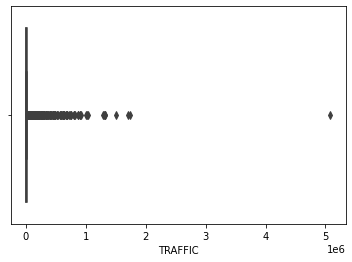

In [40]:
sns.boxplot(MTA_Traffic_per_stat['TRAFFIC']);

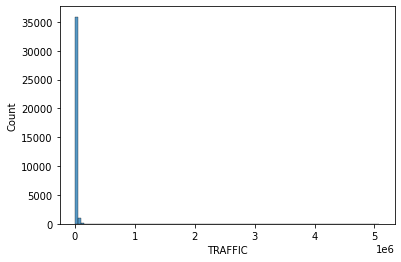

In [44]:
sns.histplot(MTA_Traffic_per_stat['TRAFFIC'],bins=100);

As we can see from the graph there are numbers that are abnormal like  5081493. to remove them, we need to calculate the upper bound for the boxplot and remove everything bigger than it. 



In [46]:
# To calculate the Q1 for the TRAFFIC 25%
Q1 = np.quantile(MTA_Traffic_per_stat.TRAFFIC, 0.25)

# To calculate the Q2 for the TRAFFIC
Q2 = np.median(MTA_Traffic_per_stat.TRAFFIC)

# To calculate the Q3 for the TRAFFIC 75%
Q3 = np.quantile(MTA_Traffic_per_stat.TRAFFIC, 0.75)

# To calculate IQR = Q3 - Q1
IQR = Q3 - Q1

#Now lets calculate the upper and lower bound 
upper_bound = Q3+(1.5*IQR)
lower_bound = Q1-(1.5*IQR)

'Upper bount value : {} , Lower bound value : {}'.format(upper_bound,lower_bound)

'Upper bount value : 24852.875 , Lower bound value : -9894.125'

Now lets have the dataframe without the outliers

In [49]:
MTA_Traffic_per_stat = MTA_Traffic_per_stat[(MTA_Traffic_per_stat["TRAFFIC"] < upper_bound) & (MTA_Traffic_per_stat["TRAFFIC"] > lower_bound)]
MTA_Traffic_per_stat

,STATION,DATE,TRAFFIC
0,1 AV,06/12/2021,20036.0
1,1 AV,06/13/2021,15884.0
2,1 AV,06/14/2021,20037.0
4,1 AV,06/16/2021,22383.0
5,1 AV,06/17/2021,23324.0
...,...,...,...
37105,ZEREGA AV,09/13/2021,3056.0
37106,ZEREGA AV,09/14/2021,3120.0
37107,ZEREGA AV,09/15/2021,3050.0
37108,ZEREGA AV,09/16/2021,2476.0




---

##Visualizing the data

now lets get to the point and find the insights from this data to help the company.

### Q1: What are the top five bussiest stations in Summer 2021 ?

to answer this question, we already have the *MTA_Traffic_per_stat* dataframe that have each station with the traffic for each day. but we want the total summer traffic for each station, so we need to group by the station and sum the traffic.

In [73]:
Top_5 = MTA_Traffic_per_stat.groupby(["STATION"]).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).head(5)
Top_5

,TRAFFIC
STATION,
103 ST-CORONA,1943643.0
1 AV,1877292.0
57 ST-7 AV,1847561.0
CROWN HTS-UTICA,1842218.0
B'WAY-LAFAYETTE,1806617.0


Now, lets plot this ...

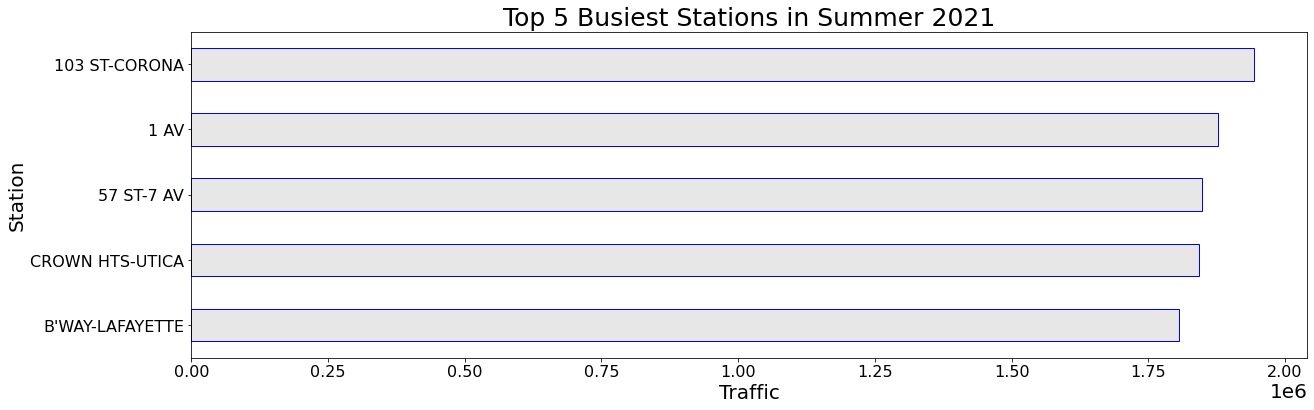

In [109]:
fig, ax = plt.subplots(figsize=(20, 6))
Top_5.sort_values(by = 'TRAFFIC').plot(kind='barh',color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue',ax=ax)

#Changing font sizes 
ax.set_title('Top 5 Busiest Stations in Summer 2021', fontsize=25)
ax.set_xlabel('Traffic', fontsize=20)
ax.set_ylabel('Station', fontsize=20)
plt.rcParams['font.size'] = '10'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(16)
ax.legend().set_visible(False)

